In [0]:
import torch
import torchvision 
from torchvision import datasets, transforms
from torch import nn, optim

In [0]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])    #normalize will only take one value as mean and std as the images are grayscale so only one color channel but if rgb then (0.5, 0.5, 0.5)

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [74]:
print(f"training set contains : {len(trainset)} images")
print(f"testing set contains : {len(testset)} images")


training set contains : 60000 images
testing set contains : 10000 images


In [75]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py


--2019-06-20 09:42:03--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



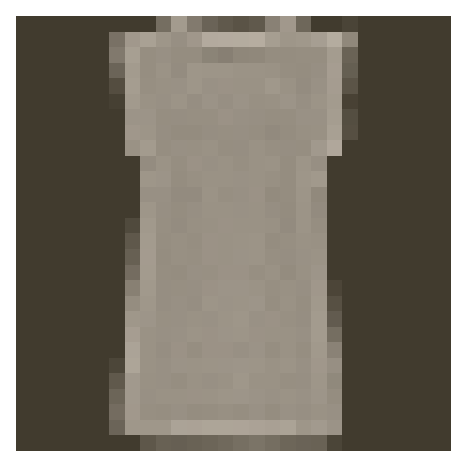

In [76]:
import helper
images, labels = next(iter(trainloader))
helper.imshow(images[0,:]);

In [77]:
print(images.shape)

torch.Size([64, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([6, 7, 0, 0, 7, 5, 1, 6, 6, 8, 0, 2, 6, 4, 8, 7, 6, 8, 2, 3, 8, 2, 2, 8,
        5, 2, 4, 0, 0, 6, 5, 9, 2, 6, 0, 6, 8, 7, 0, 4, 8, 5, 5, 6, 5, 7, 7, 0,
        4, 3, 4, 6, 9, 5, 4, 9, 7, 2, 7, 2, 6, 0, 1, 0])


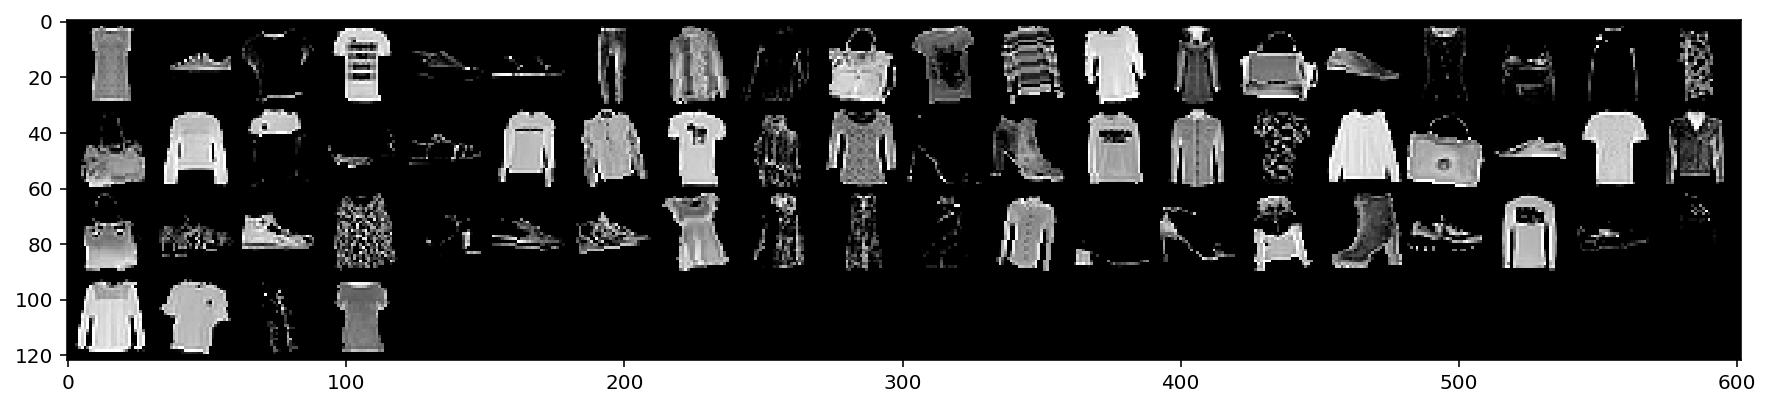

In [78]:
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (15, 15))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)

In [79]:
#
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
model = nn.Sequential(nn.Linear(784, 256), nn.ReLU(), nn.Dropout(p = 0.2), nn.Linear(256, 64), nn.ReLU(), nn.Dropout(p = 0.2), nn.Linear(64, 10), nn.LogSoftmax(dim = 1))
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.003, momentum)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [89]:
epochs = 1  #no of times neural networks goes over the entire dataset of training set
train_losses, test_losses = [], []
#training pass
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:   #this loop is called iterations which goes for len(trainloader)/batchsize times so that whole dataset is covered in mini batches in every epoch
    optimizer.zero_grad()    #clearing the gradients of the optimizer to be zero in evry turn
    images = images.flatten(start_dim = 1)  #flattening the image so that network takes the approapriate inputs 
    images = images.to(device)   #moving the tensors to cuda (or cpu if training on cpu)
    labels = labels.to(device)
    output = model(images)       #calculating the outputs of all neurons in the last layer
    loss = criterion(output, labels)   #calculating loss by applying the appropriate loss function by comparing calculated output and known lables
    loss.backward()   #keeping the track of gradients on
    optimizer.step()   #taking gradient descent step - > updating the weights of the network 
    running_loss += loss.item()   #update the running loss of train set
    #validation pass
  else:   #this runs after model passes over entire dataset (after the for loop finishes)
    test_loss = 0     
    accuracy = 0
    with torch.no_grad():   #turing the autograd off because we no longer want to keep track of gradients calculated
      model.eval()          #putting the model in evaluation mode means now no dropout layers will be used (dropout will be 0 for evaluation)
      for images, labels in testloader:
        images = images.flatten(start_dim=1)
        images = images.to(device)  
        labels = labels.to(device)
        log_ps = model(images)   #calculatin the outputs now for testing set images
        test_loss += criterion(log_ps,labels)   #calculatin losses for testing set
        ps = torch.exp(log_ps)   #taking powers of all outputs
        top_p , top_class = ps.topk(1,dim=1)   #now we have ps -> 2-d tensor containing kth (here 1) highest probabilites and labels for them , since for every image , we have all the outputs 
        #obtained but we want just the highest probaility and correspoding label for it.
        equals = top_class == labels.view(*top_class.shape)  #now we compare the label obtained above wiht the knwon label and output 1 if it predicts correct and 0 if it predicts wrong
        accuracy += torch.mean(equals.type(torch.FloatTensor))  #now we take avergae of all the predictions 
    model.train()  #putting model back to training mode after validation pass finishes
    train_losses.append(running_loss/len(trainloader))   #keeping track of overall training loss
    test_losses.append(test_loss/len(testloader))    #keeping track of overall testing loss
    #finally printing all the required info for the model
    print("Epoch: {}/{}.. ".format(e+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),"Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    

tensor([[1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1]], device='cuda:0', dtype=torch.uint8)
tensor(0.7344)
tensor([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

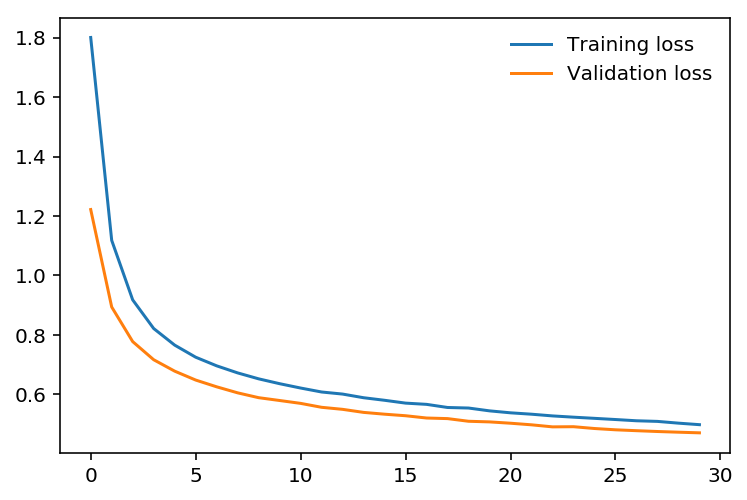

In [86]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)